In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import LabelEncoder

In [2]:
!pip install tslearn

In [3]:
# Upload Data
from google.colab import files
import io

print("Upload Gene Expression protein dataset:")
uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

Upload Gene Expression protein dataset:


Saving Gene Expression.csv to Gene Expression (1).csv


In [4]:
# Exploratory Data Analysis
print("\n=== Data Overview ===")
print(f"Dataset shape: {df.shape}")
print(f"Time points: {df.columns.tolist()}")
print("\nSample data:")
display(df.head())



=== Data Overview ===
Dataset shape: (4381, 24)
Time points: ['time', '40', '50', '60', '70', '80', '90', '100', '110', '120', '130', '140', '150', '160', '170', '180', '190', '200', '210', '220', '230', '240', '250', '260']

Sample data:


,time,40,50,60,70,80,90,100,110,120,...,170,180,190,200,210,220,230,240,250,260
0,YAL001C,-0.070,-0.23,-0.100,0.03,-0.04,-0.12,-0.28,-0.44,-0.09,...,0.59,0.34,-0.28,-0.09,-0.44,0.31,0.03,0.57,0.00,0.010
1,YAL014C,0.215,0.09,0.025,-0.04,-0.04,-0.02,-0.51,-0.08,0.00,...,-0.30,-0.38,0.07,-0.04,0.13,-0.06,-0.26,-0.10,0.27,0.235
2,YAL016W,0.150,0.15,0.220,0.29,-0.10,0.15,-0.73,0.19,-0.15,...,0.12,-0.17,0.11,-0.15,0.03,-0.26,-0.34,-0.34,0.25,0.190
3,YAL020C,-0.350,-0.28,-0.215,-0.15,0.16,-0.12,0.26,0.00,0.13,...,0.07,0.61,-0.20,0.49,-0.43,0.80,-0.47,1.01,-0.36,-0.405
4,YAL022C,-0.415,-0.59,-0.580,-0.57,-0.09,-0.34,0.49,0.32,1.15,...,-0.48,-0.40,-0.59,0.54,-0.09,1.03,0.08,0.57,-0.26,-0.310


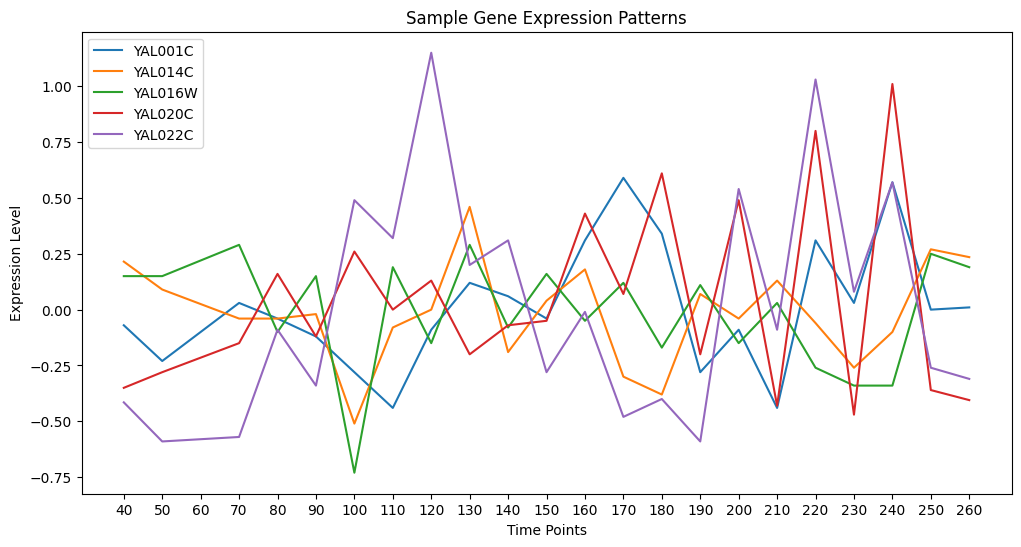

In [5]:
# Gene expression patterns
plt.figure(figsize=(12,6))
# Select only the time point columns (excluding 'time')
time_points = df.columns[1:]
for i in range(5):  # Plot first 5 genes
    plt.plot(time_points, df.iloc[i, 1:], label=df.iloc[i, 0]) # Use time_points for x, gene expression values for y, and the gene name from the 'time' column as label
plt.xlabel('Time Points')
plt.ylabel('Expression Level')
plt.title('Sample Gene Expression Patterns')
plt.legend()
plt.show()

In [6]:
# Feature Engineering
def extract_temporal_features(series):
    """Extracts features from time series data"""
    # Convert series to numpy array of floats
    series_numeric = np.array(series, dtype=float)
    return {
        'mean_exp': series_numeric.mean(),
        'std_exp': series_numeric.std(),
        'max_exp': series_numeric.max(),
        'min_exp': series_numeric.min(),
        'range_exp': series_numeric.max() - series_numeric.min(),
        'slope': np.polyfit(range(len(series_numeric)), series_numeric, 1)[0],
        'abs_area': np.trapz(np.abs(series_numeric)),
        'positive_ratio': (series_numeric > 0).mean()
    }

# Apply feature engineering
print("\nExtracting temporal features...")
temp_features = pd.DataFrame([extract_temporal_features(row[1:]) for _, row in df.iterrows()])
temp_features.index = df.index


Extracting temporal features...


/tmp/ipython-input-6-3331707243.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  'abs_area': np.trapz(np.abs(series_numeric)),



Running PCA for visualization...


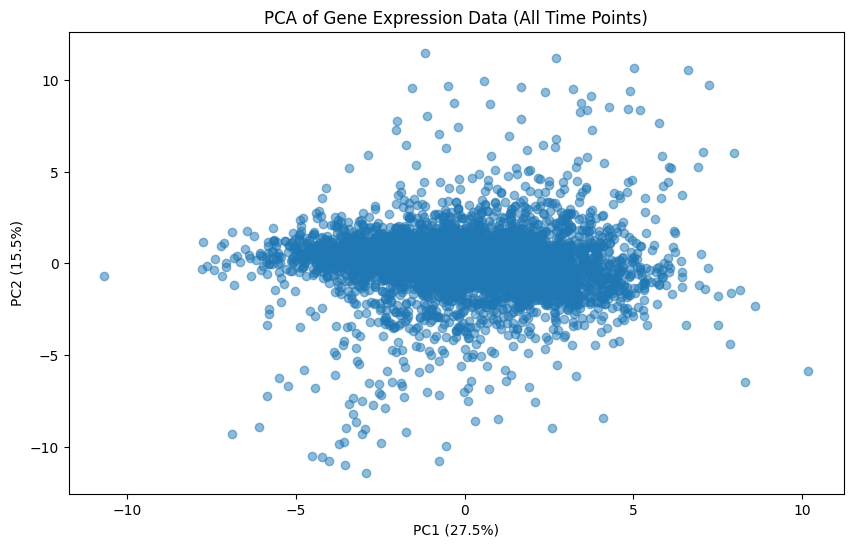

In [7]:
# Dimensionality Reduction and Visualization
# Standardize data
scaler = StandardScaler()
# Select only the time point columns (excluding 'time') for scaling
scaled_data = scaler.fit_transform(df.iloc[:, 1:])

# PCA for visualization
print("\nRunning PCA for visualization...")
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)

plt.figure(figsize=(10,6))
plt.scatter(pca_results[:,0], pca_results[:,1], alpha=0.5)
plt.title('PCA of Gene Expression Data (All Time Points)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.show()


Running Fast Clustering...


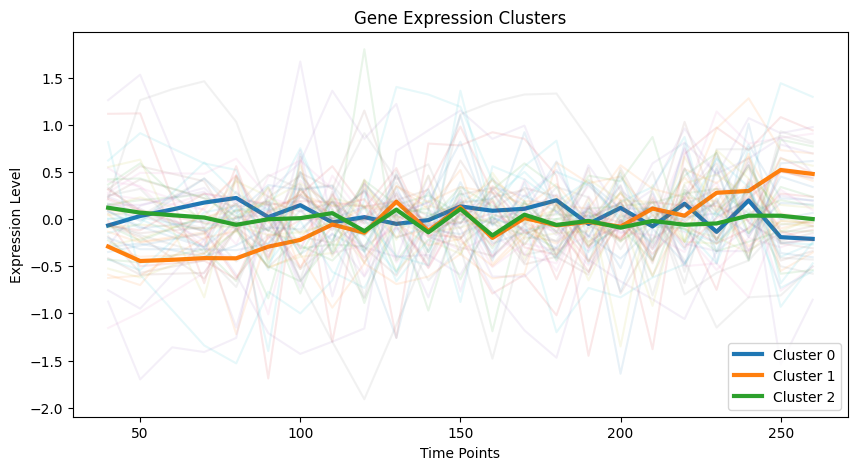

In [12]:
# Clustring
print("\nRunning Fast Clustering...")
# Exclude the 'time' column which contains strings
data = df.iloc[:, 1:].values

# Simple feature extraction (mean and trend)
features = np.column_stack([
    data.mean(axis=1),
    np.array([np.polyfit(range(len(row)), row, 1)[0] for row in data])
])

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # Added n_init for KMeans
clusters = kmeans.fit_predict(features)

# Cluster Visualization
plt.figure(figsize=(10,5))
# Use the time point columns for the x-axis
time_points_numeric = df.columns[1:].astype(int)
for cluster_id in np.unique(clusters):
    cluster_data = data[clusters == cluster_id]
    # Plot a sample of genes from the cluster
    for expr in cluster_data[:20]:  # Show max 20 per cluster
        plt.plot(time_points_numeric, expr, alpha=0.1)
    # Calculate and plot the mean expression profile for the cluster
    mean_cluster_expr = cluster_data.mean(axis=0)
    plt.plot(time_points_numeric, mean_cluster_expr,
             linewidth=3, label=f'Cluster {cluster_id}')
plt.title("Gene Expression Clusters")
plt.xlabel("Time Points") # Added x-axis label
plt.ylabel("Expression Level") # Added y-axis label
plt.legend()
plt.show()


Running PCA...


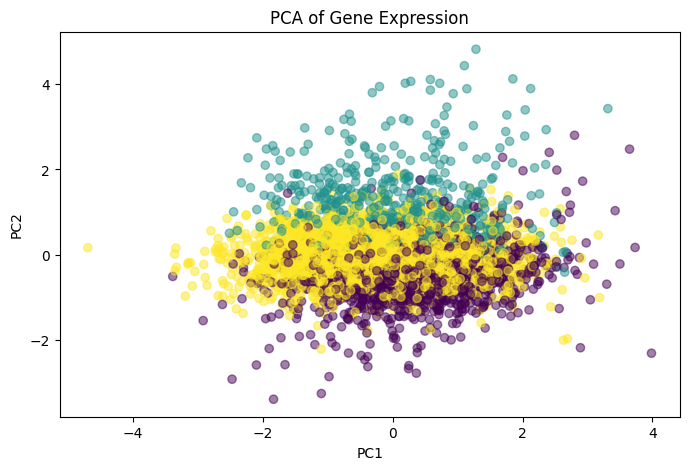

In [13]:
# 6. Basic PCA Visualization
print("\nRunning PCA...")
pca = PCA(n_components=2)
pca_results = pca.fit_transform(data)

plt.figure(figsize=(8,5))
plt.scatter(pca_results[:,0], pca_results[:,1], c=clusters, alpha=0.5)
plt.title("PCA of Gene Expression")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



In [20]:
# Quick Cluster Analysis
print("\nCluster Sizes:")
print(pd.Series(clusters).value_counts())

# Simple Gene Search
def find_similar_genes(gene_name, n=5):
    if gene_name in df.index:
        target = df.loc[gene_name].values
        similarities = []
        for row in data:
            # Handle cases where either array is constant
            if np.all(target == target[0]) or np.all(row == row[0]):
                similarities.append(0)  # Assign 0 correlation for constant series
            else:
                similarities.append(np.corrcoef(target, row)[0,1])
        similarities = np.array(similarities)
        similar_genes = df.iloc[similarities.argsort()[::-1][1:n+1]]

        plt.figure(figsize=(10,4))
        plt.plot(df.columns, target, label=gene_name, linewidth=2)
        for gene in similar_genes.index:
            plt.plot(df.columns, df.loc[gene], alpha=0.6)
        plt.title(f"Genes Similar to {gene_name}")
        plt.legend()
        plt.show()
        return similar_genes
    else:
        print("Gene not found!")

print("\nAnalysis complete!")


Cluster Sizes:
2    2444
0    1427
1     510
Name: count, dtype: int64

Analysis complete!
